# Phase 1 - Ingestion and Cleaning

In the Phase 2 of the Case Study, we will carry out the following steps:
  - Ingest raw downloaded data
  - Output a combined dataset ready for analysis and modeling

In [2]:
import pandas as pd
import os
from sys import platform
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pickle
import seaborn

In [3]:
# A helper function that you'll be using while reading the raw files
def is_integer(x):
    '''
    This function returns True if x is an integer, and False otherwise
    '''
    try:
        return (int(x) == float(x))
    except:
        return False

## Parameters

In [4]:
# Define the directories that contain the files downloaded
dir_cs = os.getcwd() + "/1805_download" # path to the directory where all the *.csv.zip files are located

# Define the output path for the pickle
pickle_file =  "./clean_data.pickle" # path to save cleaned data

In [5]:
# Identify the columns we'll be keeping from the dataset
cols_to_pick = ['id', 'loan_amnt', 'funded_amnt', 'term', 'int_rate', 'installment', 'grade', 'emp_length',
'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status',
'purpose', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'open_acc', 'pub_rec',
'fico_range_high', 'fico_range_low', 'revol_bal', 'revol_util', 'total_pymnt',
'last_pymnt_d', 'recoveries'] # list of features to use for this study as indicated in the handout

# Identify the type of each of these column based on your CS-Phase 1 response
float_cols = ['loan_amnt', 'funded_amnt', 'installment','annual_inc','dti','delinq_2yrs','open_acc','pub_rec',
              'fico_range_high', 'fico_range_low','revol_bal','total_pymnt','recoveries']
cat_cols = ['term','grade', 'emp_length','home_ownership','verification_status', 'loan_status', 'purpose'] # categorical features
perc_cols = ['int_rate', 'revol_util']
date_cols = ['issue_d', 'earliest_cr_line', 'last_pymnt_d']

# Ensure that we have types for every column
assert set(cols_to_pick) - set(float_cols) - set(cat_cols) - set(perc_cols) - set(date_cols) == set(["id"])

In [51]:
# Some of the columns selected will not be used directly in the model,
# but will be used to generate other features.
#
# Create variables specifying the features that will be used

# All categorical columns other than "loan_status" will be used as
# discrete features

discrete_features = list(set(cat_cols) - set(["loan_status"]))

# All numeric columns will be used as continuous features
continuous_features = list(float_cols + perc_cols)

## Ingestion
Ingest the data files from both sets, perform consistency checks, and prepare one single file for each set

In [7]:
def ingest_files(directory):
    '''
    This function will ingest every file in the specified directory
    into a pandas dataframe. It will return a dictionary containing
    these dataframes, keyed by the file name.
    
    We assume the directory contains files directly downloaded from
    the link given in the handout, and *only* those files. Thus, we 
    assume the files are zipped (pd.read_csv can read zipped files) 
    and we assume the first line in each file needs to be skipped.
    
    Note that each file will be read *without* formatting
    '''
    
    # If the directory has no trailing slash, add one
    if directory[-1] != "/":
        directory =  directory + "/"
    all_files = []
    for file in os.listdir(directory):
        if file.endswith(".zip"):
            all_files.append(file)
    output = {}
    
    print("Directory " + directory + " has " + str(len(all_files)) + " files:")
    for i in all_files:
        print("    Reading file " + i)
        output[i] = pd.read_csv(directory + i, dtype='str', header=1) # read each with dtype='str' and skip_rows =1
        
        # Some of the files have "summary" lines that, for example
        # read "Total number of loans number in Policy 1: ....."
        # To remove those lines, find any lines with non-integer IDs
        # and remove them
        l = output[i]['id'].tolist()
        invalid_rows = [x for x, y in enumerate(l) if not is_integer(y)]# mask rows that have non-integer IDs. Use is_integer method
        if len(invalid_rows) != 0:
            print("Found " + str(len(invalid_rows)) + " invalid rows which were removed")
            output[i].drop(output[i].index[invalid_rows])
    
    return output # return dictionary of dataframe

In [8]:
# Ingest the set of files we downloaded using the defined method "ingest_files"
files_cs = ingest_files(dir_cs) # dictioary of (filename, dataframe) as (key, value)

Directory C:\Users\Wenting Zhao\Documents\ML\case study\Phase 2/1805_download/ has 12 files:
    Reading file LoanStats3a_securev1.csv.zip
Found 3 invalid rows which were removed
    Reading file LoanStats3b_securev1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats3c_securev1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats3d_securev1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q2.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q3.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q4.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2017Q1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2017Q2.csv.zip
Found 2 invalid rows which were removed
    Reading file 

### Combine the files

In [9]:
li = []
for key, value in files_cs.items():
    li.append(value)
data_cs = pd.concat(li, ignore_index=True) # combine "files_cs" into a pandas dataframe
              # resent index with drop = True

## Prepare Final Dataset

In [10]:
# Keep only the columns of interest from 'data_cs'
final_data = data_cs[data_cs.columns[data_cs.columns.isin(cols_to_pick)]]


In [11]:
print("Starting with " + str(len(final_data)) + " rows")

Starting with 1765451 rows


### Typecast the columns

In [12]:
# Remember that we read the data as string (without any formatting). 
# Now we would typecast the columns based on feature types which you found out in CS Phase 1

for i in float_cols:
    final_data[i] = final_data[i].astype('float') # typecast float columns

C:\Users\Wenting Zhao\Anaconda4\envs\py36\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [13]:
def clean_perc(x):
    if pd.isnull(x):
        return np.nan
    else:
        return float(x.strip()[:-1])

for i in perc_cols:
    final_data[i] = final_data[i].apply(clean_perc) # apply clean_perc to percentage columns

C:\Users\Wenting Zhao\Anaconda4\envs\py36\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [14]:
def clean_date(x):
    if pd.isnull(x):
        return None
    else:
        return datetime.datetime.strptime( x, "%b-%Y").date()

for i in date_cols:
    final_data[i] = final_data[i].apply(clean_date) # typecast date cloumns to datatime using clean_date

C:\Users\Wenting Zhao\Anaconda4\envs\py36\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [15]:
for i in cat_cols:
    final_data[i] = final_data[i].replace(np.nan, None, regex=True)
    final_data[i] = final_data[i].replace(r'\s+', None, regex=True,)# for categorical features if the value is null/empty set it to None

C:\Users\Wenting Zhao\Anaconda4\envs\py36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Wenting Zhao\Anaconda4\envs\py36\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## Calculate returns for each loan

In [16]:
# Define the names of the four returns we'll be calculating as described in Q.6
# ret_PESS: Pessimistic return
# ret_OPT: Optimistic return
# ret_INTa, ret_INTb: Method3 at two differnt values of "i"
ret_cols = ["ret_PESS", "ret_OPT", "ret_INTa", "ret_INTb"]

In [17]:
# Remove all rows for loans that were paid back on the days they were issued
final_data['loan_length'] = (final_data.last_pymnt_d - final_data.issue_d) / np.timedelta64(1, 'M')
n_rows = len(final_data)

loan_length_greater_than_0 = final_data['loan_length'] != 0
final_data = final_data[loan_length_greater_than_0] # select rows where loan_length is not 0. 

print("Removed " + str(n_rows - len(final_data)) + " rows")

C:\Users\Wenting Zhao\Anaconda4\envs\py36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Removed 6218 rows


### M1-Pessimistic Method

In [18]:
final_data.columns

Index(['id', 'loan_amnt', 'funded_amnt', 'term', 'int_rate', 'installment',
       'grade', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'purpose', 'dti',
       'delinq_2yrs', 'earliest_cr_line', 'fico_range_low', 'fico_range_high',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_pymnt',
       'recoveries', 'last_pymnt_d', 'loan_length'],
      dtype='object')

In [19]:
# Calculate the return using a simple annualized profit margin
# Pessimistic definition (Handout 6a.) (M1)

final_data['term_num'] = final_data.term.str.extract('(\d+)',expand=False).astype(int) # length of loan in months

final_data['ret_PESS'] = ((final_data['total_pymnt'] - final_data['funded_amnt']) / 
                          final_data['funded_amnt']) * (12 / final_data['term_num'])

In [20]:
criteria1 = final_data['loan_status'] == 'Fully Paid'
criteria2 = final_data['loan_status'] == 'Charged Off'
final_data[criteria1 | criteria2].groupby('grade').mean()

,loan_amnt,funded_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,open_acc,pub_rec,revol_bal,revol_util,total_pymnt,recoveries,loan_length,term_num,ret_PESS
grade,,,,,,,,,,,,,,,,,,
A,13720.675783,13705.922743,7.226147,419.678318,87552.821959,15.334059,0.183057,727.115618,731.116134,11.819105,0.104012,17953.620162,39.671009,14416.940089,43.072409,21.552470,36.604167,0.016534
B,13099.002608,13087.092031,10.850455,403.002255,75614.074570,17.115259,0.309732,697.185753,701.185835,11.372827,0.209916,15938.189656,51.553367,13715.911024,103.314169,20.614325,38.700331,0.015532
C,13994.158359,13986.814639,14.067120,422.951086,72247.026682,18.559948,0.344667,687.684668,691.684703,11.457227,0.242380,15638.311975,55.996011,14190.983843,206.515938,19.037213,42.293356,0.005764
D,15100.479466,15092.466880,17.529922,464.363825,69926.527940,19.702807,0.358861,682.961538,686.961538,11.509335,0.245029,15349.312189,58.734568,14855.219497,333.777717,18.600838,44.699509,-0.000147
E,17692.437972,17667.081249,20.716908,525.910621,72458.833358,20.388148,0.355929,681.687331,685.687331,11.824565,0.239950,16334.950874,59.639968,16751.342627,530.525608,17.768241,50.878259,-0.009972
F,19107.094982,19073.208707,24.453986,580.716116,73742.936752,20.502070,0.363597,679.425640,683.425679,11.978212,0.238918,16058.178932,60.549683,17517.538379,722.631428,16.897006,54.440587,-0.015333
G,20701.586069,20680.904318,27.082773,654.669567,77288.174763,20.696986,0.379474,677.766193,681.766193,12.231884,0.243567,16806.380804,59.994163,18296.768385,824.464336,14.691292,56.362023,-0.027774


### M2-Optimistic Method

In [21]:
# Assuming that if a loan gives a positive return, we can
# immediately find a similar loan to invest in; if the loan
# takes a loss, we use M1-pessimistic to compute the return

final_data['ret_OPT'] = ((final_data['total_pymnt'] - final_data['funded_amnt']) / 
                          final_data['funded_amnt']) * (12 / final_data['loan_length'])

final_data.loc[final_data.ret_OPT < 0,'ret_OPT'] = ((final_data['total_pymnt'] - final_data['funded_amnt']) / 
                          final_data['funded_amnt']) * (12 / final_data['term_num'])

### Method 3

In [22]:
def ret_method_3(T, i):
    '''
    Given an investment time horizon (in months) and re-investment
    interest rate, calculate the return of each loan
    '''
    
    # Assuming that the total amount paid back was paid at equal
    # intervals during the duration of the loan, calculate the
    # size of each of these installment
    actual_installment = (final_data.total_pymnt - final_data.recoveries) /final_data.term_num

    # Assuming the amount is immediately re-invested at the prime
    # rate, find the total amount of money we'll have by the end
    # of the loan
    cash_by_end_of_loan = actual_installment* (1-(1+i/12)**final_data.term_num)/(1-(1+i/12)) # compute the quantity given in [] in eq.2.3 of handout
    cash_by_end_of_loan = cash_by_end_of_loan + final_data.recoveries
    
    # Assuming that cash is then re-invested at the prime rate,
    # with monthly re-investment, until T months from the start
    # of the loan
    remaining_months = T - final_data['loan_length']
    final_return = cash_by_end_of_loan *((1+i/12)**remaining_months)

    # Find the percentage return
    ret_val = (12/T) * (final_return-final_data['funded_amnt'])/final_data['funded_amnt']
    return ret_val

In [23]:
final_data['ret_INTa'] = ret_method_3(60,0.002) # call ret_method_3 with T=60, i=0.002
final_data['ret_INTb'] = ret_method_3(60,0.005) # call ret_method_3 with T=60, i=0.005

### Visualize the variables

In [24]:
def visualize_float_columns():
    '''
    This function visualizes Box-and-whisker plots for continuous variables
    '''
    
    # FLoat columns
    for i in float_cols + perc_cols + ret_cols:
        seaborn.boxplot(final_data[i])

        # Print the three highest values
        highest_vals = sorted(final_data[i].dropna(),reverse=True)[0:3] # get 3 highest values
        
        smallest_val = min(final_data[i])
        
        plt.text(smallest_val, -0.3, highest_vals[0])
        plt.text(smallest_val, -0.2, highest_vals[1])
        plt.text(smallest_val, -0.1, highest_vals[2])

        plt.show()

In [25]:
def visualize_cat_columns():
    '''
    Lists the distinct values for categorical columns
    '''
    # Categorical columns 
    for i in cat_cols:
        print("field name:"+i) # print field name
        print("number of distinct values:"+str(len(set(final_data[i]))))# print number of distinct values
        for d in set(final_data[i]):
            print(d+" occurs "+str((final_data[i] == d).sum())+" times")# for each distinct value print the number of occurances
        print("")
        print("")

In [26]:
def visualize_date_columns():
    '''
    This function visualizes a timeline density for dates
    '''
    
    # Date columns
    for i in date_cols:
        final_data[final_data[i].isnull() == False][i].apply(lambda x : str(x.year) +
                                                "-" + str(x.month)).value_counts(ascending = True).plot()
        plt.title(i + " (" + str(final_data[i].isnull().sum()) + " null values)")
        plt.show()

In [27]:
final_data

,id,loan_amnt,funded_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,...,revol_util,total_pymnt,recoveries,last_pymnt_d,loan_length,term_num,ret_PESS,ret_OPT,ret_INTa,ret_INTb
0,1077501,5000.0,5000.0,36 months,10.65,162.87,B,10+ years,RENT,24000.00,...,83.70,5863.155187,0.00,2015-01-01,37.027454,36,0.057544,0.055947,0.036114,0.038516
1,1077430,2500.0,2500.0,60 months,15.27,59.83,C,< 1 year,RENT,30000.00,...,9.40,1014.530000,122.90,2013-04-01,16.000329,60,-0.118838,-0.118838,-0.117886,-0.116436
2,1077175,2400.0,2400.0,36 months,15.96,84.33,C,10+ years,RENT,12252.00,...,98.50,3005.666844,0.00,2014-06-01,29.996509,36,0.084120,0.100956,0.052463,0.055481
3,1076863,10000.0,10000.0,36 months,13.49,339.31,C,10+ years,RENT,49200.00,...,21.00,12231.890000,0.00,2015-01-01,37.027454,36,0.074396,0.072332,0.046294,0.048800
4,1075358,3000.0,3000.0,60 months,12.69,67.79,B,1 year,RENT,80000.00,...,53.90,4066.908161,0.00,2017-01-01,61.044375,60,0.071127,0.069910,0.072417,0.074367
5,1075269,5000.0,5000.0,36 months,7.90,156.46,A,3 years,RENT,36000.00,...,28.30,5632.210000,0.00,2015-01-01,37.027454,36,0.042147,0.040978,0.026813,0.029121
6,1069639,7000.0,7000.0,60 months,15.96,170.08,C,8 years,RENT,47004.00,...,85.60,10137.840008,0.00,2016-05-01,52.994928,60,0.089653,0.101503,0.091421,0.094099
7,1072053,3000.0,3000.0,36 months,18.64,109.43,E,9 years,RENT,48000.00,...,87.50,3939.135294,0.00,2015-01-01,37.027454,36,0.104348,0.101453,0.064387,0.067077
8,1071795,5600.0,5600.0,60 months,21.28,152.39,F,4 years,OWN,40000.00,...,32.60,647.500000,190.54,2012-04-01,4.008296,60,-0.176875,-0.176875,-0.176577,-0.176122
9,1071570,5375.0,5375.0,60 months,12.69,121.45,B,< 1 year,RENT,15000.00,...,36.50,1484.590000,277.69,2012-11-01,11.039241,60,-0.144759,-0.144759,-0.144084,-0.143053


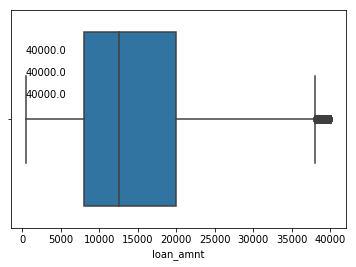

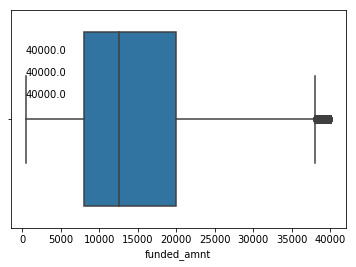

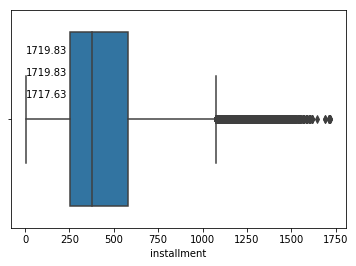

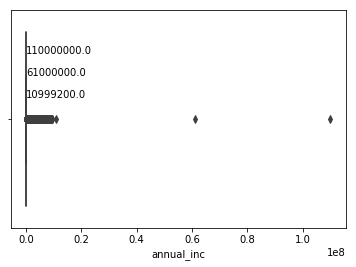

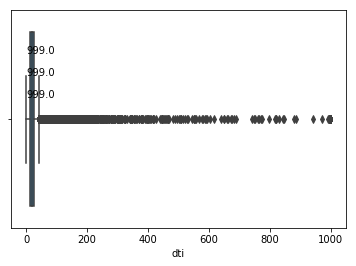

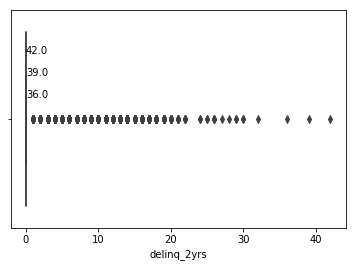

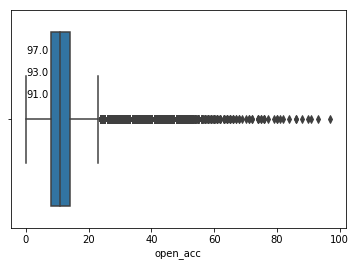

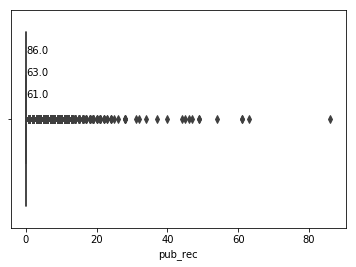

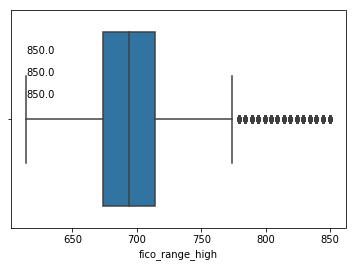

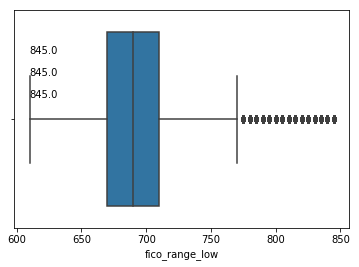

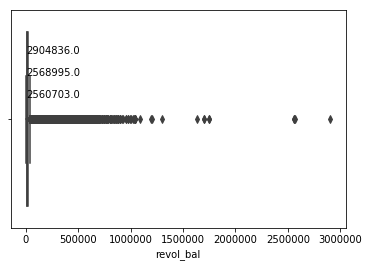

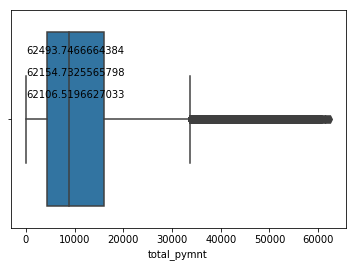

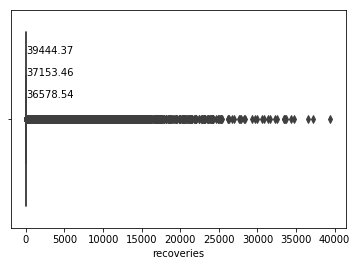

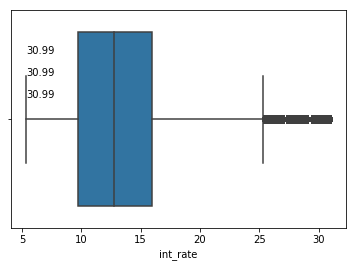

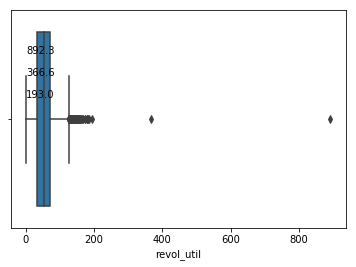

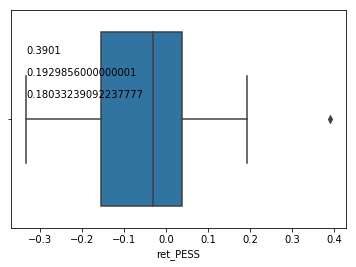

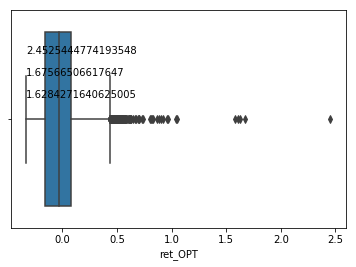

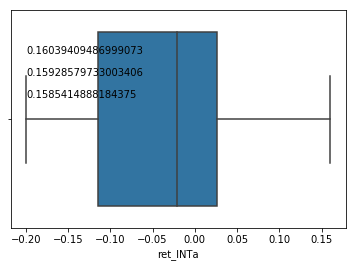

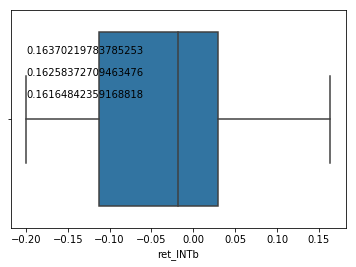

field name:term
number of distinct values:2
 36 months occurs 1260623 times
 60 months occurs 498610 times


field name:grade
number of distinct values:7
C occurs 521321 times
G occurs 11384 times
F occurs 38426 times
A occurs 296998 times
E occurs 116177 times
B occurs 520533 times
D occurs 254394 times


field name:emp_length
number of distinct values:11
9 years occurs 70661 times
4 years occurs 111680 times
2 years occurs 168379 times
< 1 year occurs 155376 times
10+ years occurs 622678 times
3 years occurs 148453 times
8 years occurs 80388 times
7 years occurs 78876 times
5 years occurs 115152 times
1 year occurs 122177 times
6 years occurs 85413 times


field name:home_ownership
number of distinct values:6
NONE occurs 54 times
RENT occurs 697225 times
ANY occurs 504 times
MORTGAGE occurs 869379 times
OWN occurs 191889 times
OTHER occurs 182 times


field name:verification_status
number of distinct values:3
Source Verified occurs 668300 times
Verified occurs 529109 times
Not Verifi

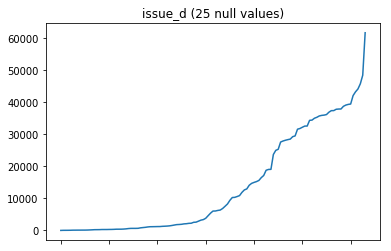

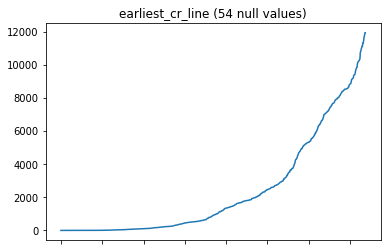

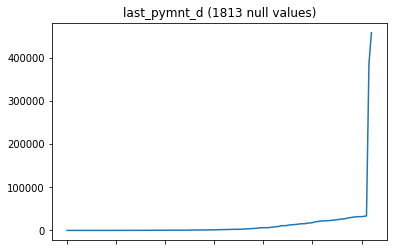

In [28]:
# visualize continuous features
visualize_float_columns()

# visulaize categorical features
visualize_cat_columns()

# visualize date columns
visualize_date_columns()

In [29]:
final_data1=final_data

### Handle outliers

In [30]:
# There are quite a few outliers. 
# Please identify top-k (decide this based on the visualization) features where outliers are most obvious
n_rows = len(final_data)

final_data = final_data[final_data['loan_amnt']<38000] # remove outliers based 1st obvious feature
final_data = final_data[final_data['funded_amnt']<38000] # remove outliers based 2nd obvious feature
final_data = final_data[final_data['installment']<1100]
final_data = final_data[final_data['annual_inc']<200000]
final_data = final_data[final_data['dti']<50]
final_data = final_data[final_data['delinq_2yrs']<10]
final_data = final_data[final_data['open_acc']<25]
final_data = final_data[final_data['pub_rec']<10]
final_data = final_data[final_data['revol_bal']<100000]
final_data = final_data[final_data['fico_range_high']<780]
final_data = final_data[final_data['fico_range_low']<770]
final_data = final_data[final_data['total_pymnt']<35000]
final_data = final_data[final_data['recoveries']<1000]
final_data = final_data[final_data['int_rate']<25]
final_data = final_data[final_data['revol_util']<150]
final_data = final_data[final_data['ret_PESS']<0.2]
final_data = final_data[final_data['ret_OPT']<0.5]
# remove outliers based kth obvious feature

print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 333679 rows


In [31]:
print(len(final_data))

1425554


In [32]:
# Remove all loans that are still current
n_rows = len(final_data)

final_data = final_data[final_data['loan_status']!='Current']

print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 663598 rows


In [33]:
# Only include loans isssued since 2010
n_rows = len(final_data)

final_data = final_data[final_data['issue_d']>=datetime.date(2010, 1, 1) ]

print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 7048 rows


### Drop null values

In [34]:
# Deal with null values. We allow cateogrical variables to be null
# OTHER than grade, which is a particularly important categorical.
# All non-categorical variables must be non-null, and we drop
# rows that do not meet this requirement

required_cols = set(cols_to_pick) - set(cat_cols) - set(["id"])
required_cols.add("grade")

n_rows = len(final_data)

for i in required_cols:
    final_data=final_data[pd.notnull(final_data[i])]# drop rows that contain null based only on "required_cols"

print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 0 rows


### Visualize clean data

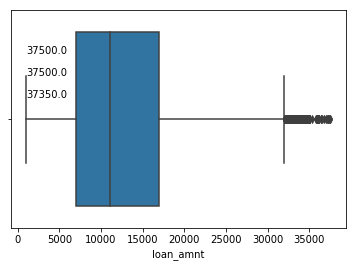

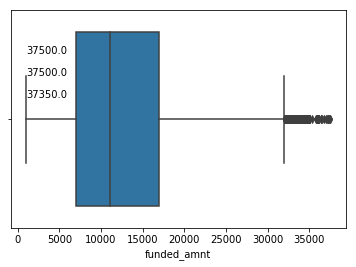

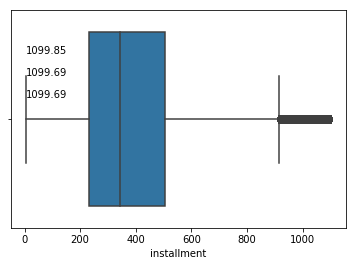

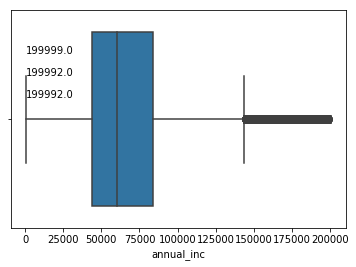

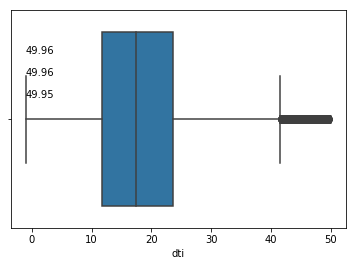

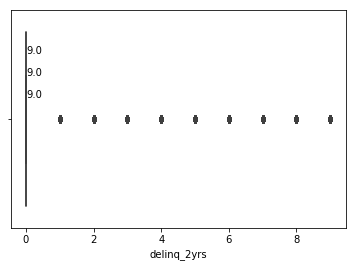

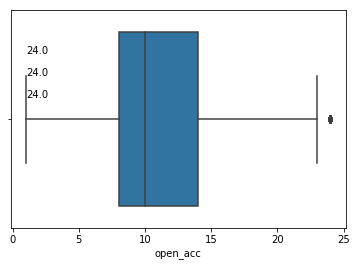

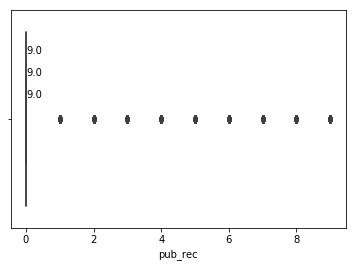

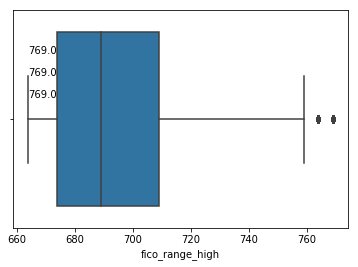

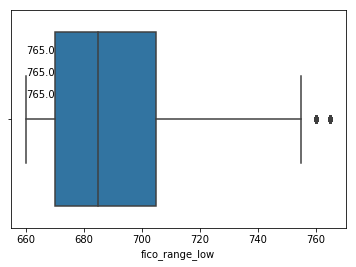

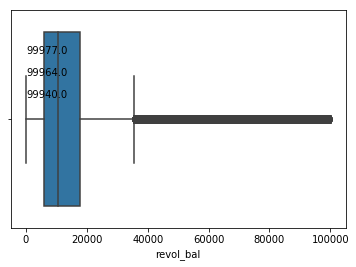

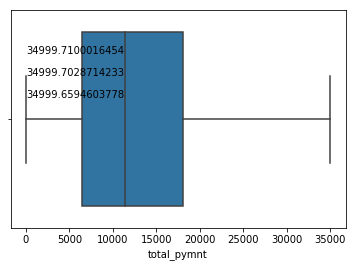

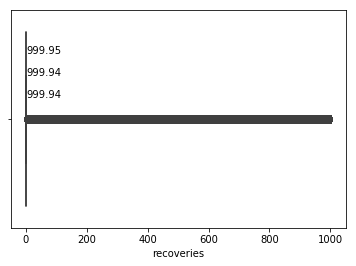

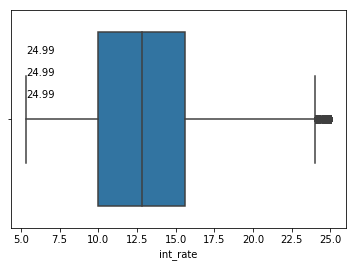

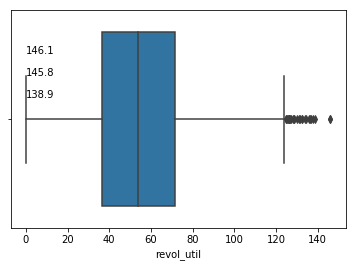

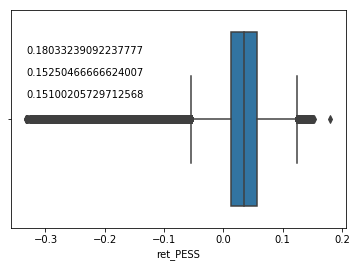

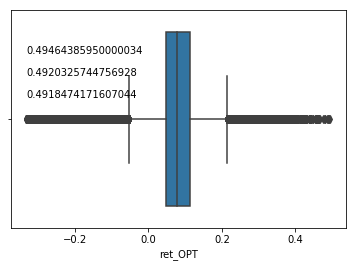

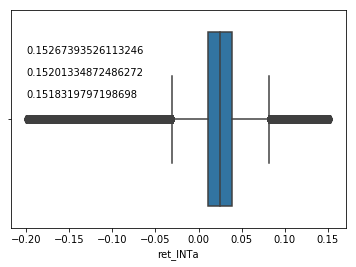

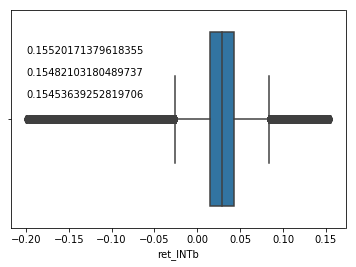

field name:term
number of distinct values:2
 36 months occurs 604623 times
 60 months occurs 150285 times


field name:grade
number of distinct values:7
C occurs 222937 times
G occurs 364 times
F occurs 11700 times
A occurs 119321 times
E occurs 48049 times
B occurs 237082 times
D occurs 115455 times


field name:emp_length
number of distinct values:11
9 years occurs 30787 times
4 years occurs 48560 times
2 years occurs 73390 times
< 1 year occurs 64097 times
10+ years occurs 254287 times
3 years occurs 64724 times
8 years occurs 37569 times
7 years occurs 37829 times
5 years occurs 51147 times
1 year occurs 53415 times
6 years occurs 39103 times


field name:home_ownership
number of distinct values:6
NONE occurs 33 times
RENT occurs 319203 times
ANY occurs 103 times
MORTGAGE occurs 358654 times
OWN occurs 76873 times
OTHER occurs 42 times


field name:verification_status
number of distinct values:3
Source Verified occurs 279907 times
Verified occurs 223842 times
Not Verified occurs 25

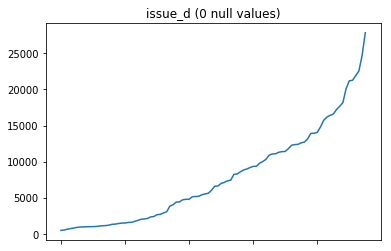

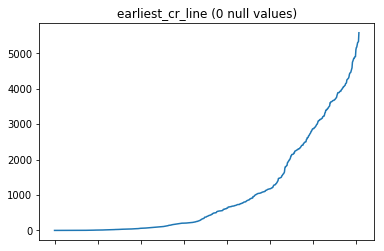

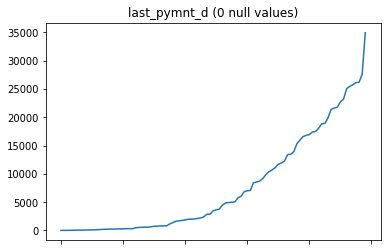

In [35]:
# Visualize the data again after cleaning
# visualize continuous features
visualize_float_columns()

# visulaize categorical features
visualize_cat_columns()

# visualize date columns
visualize_date_columns()

In [36]:
# Visualize the feature correlations
 # use sns scatter or pairplot
#g = seaborn.pairplot(final_data)
#plt.show()

In [37]:
# Visualize relation between loan status and features
# sns pairplot or scatter plot. Refer to recitations
#g = seaborn.pairplot(final_data, 
               #  x_vars=final_data.columns,
               #  y_vars=final_data['loan_status'])

#plt.show()


IndentationError: unexpected indent (<ipython-input-37-2da7dd4ebf21>, line 4)

What do you observe after removing the outliers?

### Data Exploration
Solution to Q.7 from the handout

In [38]:
# Find the percentage of loans by grade, the default by grade,
# and the return of each grade
perc_by_grade = (final_data.grade.value_counts()*100/len(final_data)).sort_index()

default_by_grade = final_data.groupby("grade").apply(lambda x : (x.loan_status != "Fully Paid").sum()*100/len(x) )
ret_by_grade_OPT = final_data.groupby("grade").apply(lambda x : np.mean(x.ret_OPT)) # average return for M2-Optimistic for each loan grade
ret_by_grade_PESS = final_data.groupby("grade").apply(lambda x : np.mean(x.ret_PESS)) # average return for M1-Pessimistic for each loan grade
ret_by_grade_INTa = final_data.groupby("grade").apply(lambda x : np.mean(x.ret_INTa)) # average return for M3
ret_by_grade_INTb = final_data.groupby("grade").apply(lambda x : np.mean(x.ret_INTb)) # average return for M3
int_rate_by_grade = final_data.groupby("grade").apply(lambda x : np.mean(x.int_rate)) # average interest rate for each grade

combined = pd.DataFrame(perc_by_grade)
combined.columns = ['perc_of_loans']
combined['perc_default'] = default_by_grade
combined['avg_int_rate'] = int_rate_by_grade
combined['return_OPT'] = ret_by_grade_OPT
combined['return_PESS'] = ret_by_grade_PESS
combined['return_INTa'] = ret_by_grade_INTa
combined['return_INTb'] = ret_by_grade_INTb

combined

,perc_of_loans,perc_default,avg_int_rate,return_OPT,return_PESS,return_INTa,return_INTb
A,15.806032,6.772488,7.323120,0.038616,0.017039,0.012219,0.015165
B,31.405416,13.210197,10.861646,0.051048,0.017114,0.012549,0.015582
C,29.531678,21.462117,14.060748,0.056785,0.008600,0.007497,0.010600
D,15.293917,27.661860,17.554981,0.065086,0.006451,0.005692,0.008807
E,6.364882,34.254615,20.539261,0.073195,0.001680,0.002401,0.005609
F,1.549858,36.401709,23.469647,0.090647,0.010940,0.009775,0.013103
G,0.048218,34.065934,22.681154,0.099912,0.033353,0.034208,0.037546


Based on the output of previous cell, write down your answers to Q.7 from the handout.

### Save a Pickle

In [52]:
continuous_features

['loan_amnt',
 'funded_amnt',
 'installment',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'open_acc',
 'pub_rec',
 'fico_range_high',
 'fico_range_low',
 'revol_bal',
 'total_pymnt',
 'recoveries',
 'int_rate',
 'revol_util']

In [47]:
final_data

,id,loan_amnt,funded_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,...,revol_util,total_pymnt,recoveries,last_pymnt_d,loan_length,term_num,ret_PESS,ret_OPT,ret_INTa,ret_INTb
0,1077501,5000.0,5000.0,36 months,10.65,162.87,B,10+ years,RENT,24000.00,...,83.70,5863.155187,0.00,2015-01-01,37.027454,36,0.057544,0.055947,0.036114,0.038516
1,1077430,2500.0,2500.0,60 months,15.27,59.83,C,< 1 year,RENT,30000.00,...,9.40,1014.530000,122.90,2013-04-01,16.000329,60,-0.118838,-0.118838,-0.117886,-0.116436
2,1077175,2400.0,2400.0,36 months,15.96,84.33,C,10+ years,RENT,12252.00,...,98.50,3005.666844,0.00,2014-06-01,29.996509,36,0.084120,0.100956,0.052463,0.055481
3,1076863,10000.0,10000.0,36 months,13.49,339.31,C,10+ years,RENT,49200.00,...,21.00,12231.890000,0.00,2015-01-01,37.027454,36,0.074396,0.072332,0.046294,0.048800
4,1075358,3000.0,3000.0,60 months,12.69,67.79,B,1 year,RENT,80000.00,...,53.90,4066.908161,0.00,2017-01-01,61.044375,60,0.071127,0.069910,0.072417,0.074367
5,1075269,5000.0,5000.0,36 months,7.90,156.46,A,3 years,RENT,36000.00,...,28.30,5632.210000,0.00,2015-01-01,37.027454,36,0.042147,0.040978,0.026813,0.029121
6,1069639,7000.0,7000.0,60 months,15.96,170.08,C,8 years,RENT,47004.00,...,85.60,10137.840008,0.00,2016-05-01,52.994928,60,0.089653,0.101503,0.091421,0.094099
7,1072053,3000.0,3000.0,36 months,18.64,109.43,E,9 years,RENT,48000.00,...,87.50,3939.135294,0.00,2015-01-01,37.027454,36,0.104348,0.101453,0.064387,0.067077
8,1071795,5600.0,5600.0,60 months,21.28,152.39,F,4 years,OWN,40000.00,...,32.60,647.500000,190.54,2012-04-01,4.008296,60,-0.176875,-0.176875,-0.176577,-0.176122
9,1071570,5375.0,5375.0,60 months,12.69,121.45,B,< 1 year,RENT,15000.00,...,36.50,1484.590000,277.69,2012-11-01,11.039241,60,-0.144759,-0.144759,-0.144084,-0.143053


In [53]:
# Remove the "total_pymnt" and "recoveries" from the list of continuous features
continuous_features = [e for e in continuous_features if e not in('total_pymnt','recoveries')]

In [54]:
continuous_features

['loan_amnt',
 'funded_amnt',
 'installment',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'open_acc',
 'pub_rec',
 'fico_range_high',
 'fico_range_low',
 'revol_bal',
 'int_rate',
 'revol_util']

Why did we remove `total_pymt` and `recoveries` from the data for the task of predicting whether to give loan or not, although these are highly predictive features?

In [55]:
# save the prepared data for modeling in next Phase.
pickle.dump( [final_data, discrete_features, continuous_features, ret_cols], open(pickle_file, "wb") )